# 中性原子量子コンピュータ上の単位円グラフを用いたQUBO/イジング問題の解法

## 依存関係のインストール

In [1]:
# !pip install bloqade-analog

## 必要なライブラリのインポート

In [2]:
from itertools import product
import math

from bloqade.analog import start
import jijmodeling as jm
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, AutoMinorLocator, FormatStrFormatter
import networkx as nx
import numpy as np

from qamomile.core.converters.qaoa import QAOAConverter
from qamomile.udm import Ising_UnitDiskGraph
from qamomile.udm.transpiler import UDMTranspiler

/Users/keisukesato/Library/Caches/pypoetry/virtualenvs/qamomile-SJ_jAwfp-py3.11/lib/python3.11/site-packages/bloqade/analog/__init__.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)


## 問題ハミルトニアンの定式化  

### `Jijmodeling`による問題の定式化
以下では、`Jijmodeling`を使用して問題ハミルトニアンを定式化する方法を示します。

In [3]:
def QUBO_problem():
    # --- プレースホルダー ---
    V = jm.Placeholder("V")
    E = jm.Placeholder("E", ndim=2)
    U = jm.Placeholder("U", ndim=2)

    n = jm.BinaryVar("n", shape=(V,))
    e = jm.Element("e", belong_to=E)

    # --- 問題の定式化 ---
    problem = jm.Problem("QUBO_Hamiltonian")

    quadratic_term = jm.sum(e, U[e[0], e[1]] * n[e[0]] * n[e[1]])
    problem += quadratic_term
    return problem


problem = QUBO_problem()
problem

In [4]:
quad = {
    (0, 0): -1.2,
    (1, 1): -3.2,
    (2, 2): -1.2,
    (0, 1): 4.0,
    (0, 2): -2.0,
    (1, 2): 3.2,
}

V_val = 3
E_val = np.array(list(quad.keys()), dtype=int)
U_val = np.zeros((V_val, V_val))
for (i, j), Jij in quad.items():
    U_val[i, j] = U_val[j, i] = Jij

instance = {
    "V": V_val,
    "E": E_val,
    "U": U_val,
}

compiled_instance = jm.Interpreter(instance).eval_problem(problem)

### `qamomile`を使った問題の変換

`compiled_instance`を取得したら、`QuantumConverter`を使用してそれを`IsingModel`クラスに変換することができます。

In [5]:
udm_converter = QAOAConverter(compiled_instance)
ising_model = udm_converter.ising_encode()
ising_model

IsingModel(quad={(0, 1): 1.0, (0, 2): -0.5, (1, 2): 0.8}, linear={0: 0.09999999999999998, 1: -0.19999999999999996, 2: 0.29999999999999993}, constant=-1.5, index_map={0: 0, 1: 1, 2: 2})

## `qamomile`によるユニットディスクグラフへのマッピング

### マッピングの実行: `UnitDiskGraph`クラス

`UnitDiskGraph`クラスは、`IsingModel`をユニットディスクグラフ（UDG）表現に変換する役割を担います。

In [6]:
udg = Ising_UnitDiskGraph(ising_model)

print(f"Converted to Unit Disk Graph:")
print(f"- {len(udg.nodes)} nodes in the grid graph")
print(f"- {len(udg.pins)} pins (nodes corresponding to original variables)")

Overwriting delta from 2.7 to 1.5
Converted to Unit Disk Graph:
- 26 nodes in the grid graph
- 3 pins (nodes corresponding to original variables)


### UDGの可視化

`networkx`と `matplotlib`を用いることで、変換後のユニットディスクグラフ（UDG）構造を視覚的に確認できます。`UnitDiskGraph`オブジェクトは、基礎となるグラフ構造へのアクセスを提供します。この可視化により、抽象的なIsing問題がユニットディスクマッピング（UDM）ガジェットを使って物理的にどのように配置されているかを理解するのに役立ちます。

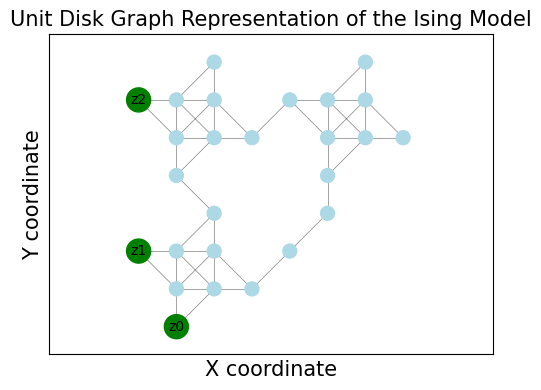

In [7]:
G_vis = udg.networkx_graph
pos = nx.get_node_attributes(G_vis, "pos")
pins = udg.pins
plt.figure(figsize=(5, 4))

# ハイライトピン（元の変数）
node_colors = ["Green" if i in pins else "lightblue" for i in G_vis.nodes()]
node_sizes = [300 if i in pins else 100 for i in G_vis.nodes()]

nx.draw_networkx_nodes(G_vis, pos, node_color=node_colors, node_size=node_sizes)
nx.draw_networkx_edges(G_vis, pos, width=0.5, alpha=0.5)

# ピンに元の変数のインデックスをラベル付けする
pin_labels = {pin: f"z{i}" for i, pin in enumerate(pins)}  # Use z_i for Ising spins
nx.draw_networkx_labels(G_vis, pos, labels=pin_labels, font_size=10)

plt.title("Unit Disk Graph Representation of the Ising Model", fontsize=15)
plt.xlabel("X coordinate", fontsize=15)
plt.ylabel("Y coordinate", fontsize=15)
plt.axis("equal")  # Ensure aspect ratio is maintained
plt.tight_layout()
plt.show()

## MWIS-UDGを **`bloqade-analog`** で解く

Ising問題をユニットディスクグラフ（UDG）上のMWIS（最大重み独立集合）問題に変換できたので、中性原子量子コンピュータのネイティブ機能を活用して解を求めることができます。

### **`bloqade-analog`** を用いた実装

`bloqade-analog`は、中性原子量子計算、特にアナログ方式や断熱プロトコルのシミュレーションに特化した Python ライブラリです。Qamomileで生成したUDGマッピングに対して`bloqade_example.py`スクリプトを使ってこれを活用できます。

**ステップ:**

1. **入力の準備:**
   - 原子の配置座標を`UnitDiskGraph`オブジェクト(`udg.nodes`)から取得します。これらの位置は、中性原子系におけるtypicalなブロッケード半径に合わせて物理単位（例：μm）にスケーリングする必要があります。
   - 各ノードの重み`udg.nodes[i].weight`を取得します（通常は正規化された値を使用）。
   - パルスパラメータを定義します：
     - 最大ラビ周波数`Omega_max`
     - 最大デチューニング`delta_max`
     - 進化時間`t_max`

In [8]:
LOCATION_SCALE = 5.0  # 希望するブロケード半径とハードウェアに基づいて調整する

locations = udg.qubo_result.qubo_grid_to_locations(LOCATION_SCALE)
weights = udg.qubo_result.qubo_result_to_weights()

print(f"Node weights: {weights}")
print(f"Node locations: {locations}")

Node weights: [np.float64(1.3), np.float64(1.7999999999999998), np.float64(1.6), np.float64(5.0), np.float64(7.0), np.float64(3.0), np.float64(6.5), np.float64(5.5), np.float64(7.0), np.float64(5.0), np.float64(3.0), np.float64(5.5), np.float64(6.5), np.float64(1.4), np.float64(3.0), np.float64(3.0), np.float64(3.0), np.float64(3.0), np.float64(3.0), np.float64(3.0), np.float64(5.2), np.float64(6.8), np.float64(6.8), np.float64(5.2), np.float64(1.7), np.float64(1.2000000000000002)]
Node locations: [(0.0, 10.0), (0.0, 30.0), (5.0, 0.0), (5.0, 5.0), (5.0, 10.0), (5.0, 20.0), (5.0, 25.0), (5.0, 30.0), (10.0, 5.0), (10.0, 10.0), (10.0, 15.0), (10.0, 25.0), (10.0, 30.0), (10.0, 35.0), (15.0, 5.0), (15.0, 25.0), (20.0, 10.0), (20.0, 30.0), (25.0, 15.0), (25.0, 20.0), (25.0, 25.0), (25.0, 30.0), (30.0, 25.0), (30.0, 30.0), (30.0, 35.0), (35.0, 25.0)]


2.  **プログラムの定義：** `bloqade.analog`を使って原子の配置とパルスシーケンスを定義する。

In [9]:
def solve_ising_bloqade(locations, weights, delta_max=60.0, Omega_max=15.0, t_max=4.0):
    locations_array = np.array(locations)
    centroid = locations_array.mean(axis=0)
    centered_locations = locations_array - centroid
    locations = list(map(tuple, centered_locations))

    lw = len(weights)
    weights_norm = [x / max(weights) for x in weights]

    def sine_waveform(t):
        return Omega_max * math.sin(math.pi * t / t_max) ** 2

    def linear_detune_waveform(t):
        return delta_max * (2 * t / t_max - 1)

    program = (
        start.add_position(locations)
        .rydberg.detuning.scale(weights_norm)
        .fn(linear_detune_waveform, t_max)
        .amplitude.uniform.fn(sine_waveform, t_max)
    )

    return program


program = solve_ising_bloqade(locations, weights)

3.  **シミュレーションの実行：** Bloqadeのエミュレータを使ってプログラムを実行する。

In [10]:
blockade_radius = (
    LOCATION_SCALE * 1.5
)  # ブロケード半径は対角ノードをカバーするように設定されている（1：√2）
emu_results = program.bloqade.python().run(
    shots=10000, solver_name="dop853", blockade_radius=blockade_radius
)

report = emu_results.report()
counts = report.counts()[0]

sorted_counts = {
    k: v for k, v in sorted(counts.items(), key=lambda item: item[1], reverse=True)
}

print("\nBloqade Simulation Results (Top 5):")
for i, (bitstring, count) in enumerate(list(sorted_counts.items())[:5]):
    print(f" {i+1}. Bitstring: {bitstring} (Count: {count})")


Bloqade Simulation Results (Top 5):
 1. Bitstring: 10010011111101011001110101 (Count: 681)
 2. Bitstring: 11010101111110011001110101 (Count: 324)
 3. Bitstring: 10010011111101011101101110 (Count: 314)
 4. Bitstring: 11010101111110001101101110 (Count: 313)
 5. Bitstring: 10110011111101011001110101 (Count: 292)


### Bloqadeのエミュレータからの結果の可視化

Bloqadeのエミュレータから得られた結果を可視化することができる。赤いノードは`Bitstring`のマッピングを示している。

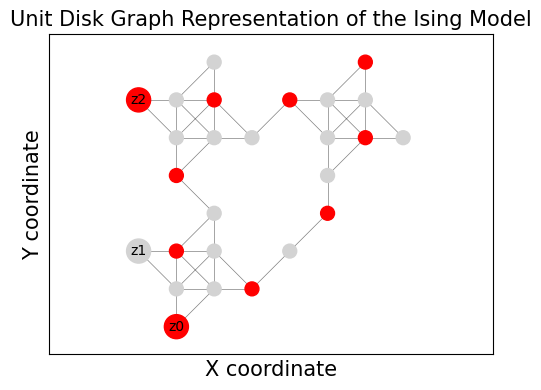

In [11]:
G_vis = udg.networkx_graph
pos = nx.get_node_attributes(G_vis, "pos")

plt.figure(figsize=(5, 4))

bitstr = list(sorted_counts.items())[:2][0][0]

# ビット値に基づいてノードの色とサイズを変更する
node_colors = ["red" if b == "0" else "lightgray" for b in bitstr]
node_sizes = [300 if i in pins else 100 for i in G_vis.nodes()]

nx.draw_networkx_nodes(G_vis, pos, node_color=node_colors, node_size=node_sizes)
nx.draw_networkx_edges(G_vis, pos, width=0.5, alpha=0.5)

# ピンに元の変数のインデックスをラベル付けする
pin_labels = {pin: f"z{i}" for i, pin in enumerate(pins)}  # 偉人ぐスピンとして z_i を使う
nx.draw_networkx_labels(G_vis, pos, labels=pin_labels, font_size=10)

plt.title("Unit Disk Graph Representation of the Ising Model", fontsize=15)
plt.xlabel("X coordinate", fontsize=15)
plt.ylabel("Y coordinate", fontsize=15)
plt.axis("equal")  # アスペクト比が維持されるようにする
plt.tight_layout()
plt.show()

### Bloqadeのエミュレータ結果を`sampleset`結果に変換する

先に得られたエミュレータの結果から、`udm_converter.decode`を使ってそれらをsamplesetに変換することができる。`sampleset`を用いることで、目的関数値の分布を調べることができる。

In [12]:
transpiler = UDMTranspiler(udg, V_val)
sampleset = udm_converter.decode(transpiler, counts)

### 最も低い解を確認する

In [13]:
sampleset.best_feasible

Solution(raw=<builtins.Solution object at 0x1214a66d0>, annotations={})

### 古典的手法を確認する

In [14]:
Q = np.array([[-1.2, 4.0, -2.0], [4.0, -3.2, 3.2], [-2.0, 3.2, -1.2]])


def Solve_Q(Q: np.ndarray, x: np.ndarray) -> float:
    E = np.dot(np.diag(Q), x)
    n = len(x)
    for i in range(n):
        for j in range(i + 1, n):
            E += Q[i, j] * x[i] * x[j]
    return E


energies = {}
for bits in product([0, 1], repeat=3):
    x = np.array(bits)
    energy = Solve_Q(Q, x)
    energies[bits] = energy
min_config, min_energy = min(energies.items(), key=lambda item: item[1])
print("min_config: ", min_config)
print("min_energy: ", min_energy)

min_config:  (1, 0, 1)
min_energy:  -4.4


## 結果の評価

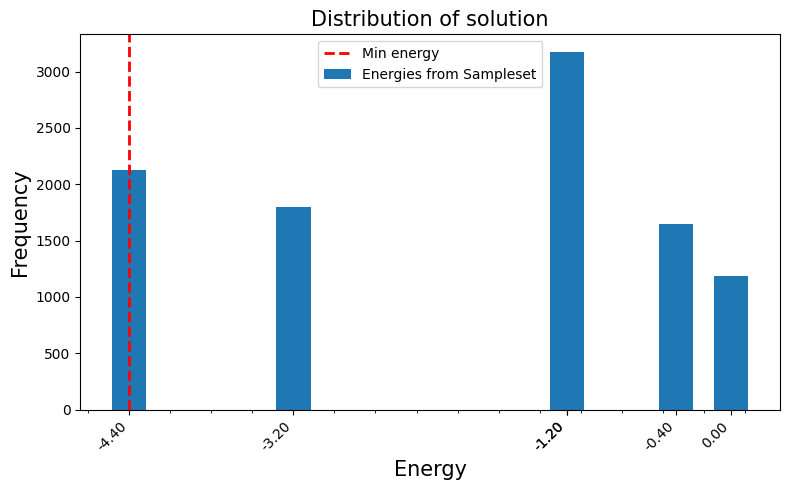

In [15]:
energies = []
freqs = []
# Create a dictionary to group energies and count their frequencies
from collections import defaultdict
energy_freq = defaultdict(int)

for sample_id in sampleset.sample_ids:
    sample = sampleset.get(sample_id)
    energy_freq[sample.objective] += 1

energies = list(energy_freq.keys())
freqs = list(energy_freq.values())

plt.figure(figsize=(8, 5))
plt.bar(energies, freqs, width=0.25, label="Energies from Sampleset")

ax = plt.gca()
ax.set_xticks(energies)
ax.set_xticklabels([f"{e:.2f}" for e in energies], rotation=45, ha="right")
ax.axvline(min_energy, color="red", linestyle="--", linewidth=2, label="Min energy")

ax.xaxis.set_minor_locator(AutoMinorLocator(4))

plt.title("Distribution of solution", fontsize=15)
plt.ylabel("Frequency", fontsize=15)
plt.xlabel("Energy", fontsize=15)
plt.legend(loc="upper center")
plt.tight_layout()
plt.show()